# Import libraries

In [6]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

# MNIST preprocessing

In [3]:
# packing and unpacking images
def packcw(A,nr,nc):
    x = (A.T).reshape(nr*nc,1)
    return x

def unpackcw(x,nr,nc):
    A = x.reshape(nc,nr)
    return A.T

def packrw(A,nr,nc):
    x = A.reshape(nr*nc,1)
    return x

def unpackrw(x,nr,nc):
    A = x.reshape(nr,nc)
    return A

# generates a 784 element mask with columns deleted
# from the right side of the image towards the left
def generateColumnMask(delColumns):
    mask = np.ones((28, 28))
    mask[:, (28 - delColumns):] = 0
    maskVec = packcw(mask, 28, 28)
    return maskVec

# generate a 784 element mask with a square, with side
# length (sideLength), zero'd out of the middle
def generateCenterSquareMask(sideLength):
    mask = np.ones((28, 28))
    leftIdx = (28 - sideLength)/2
    rightIdx = (28 + sideLength)/2
    mask[leftIdx:rightIdx, leftIdx:rightIdx] = 0
    maskVec = packcw(mask, 28, 28)
    return maskVec

# zero out indices of a vector for a data matrix
# for a given mask
def hideData(data, mask):
    # copy the data
    newData = data.copy()
    
    # get indices from the mask
    x_idx = np.where([mask==1])[1]
    y_idx = np.where([mask==0])[1]
    
    # apply the mask
    newData[y_idx, :] = 0
    
    return newData, data[x_idx, :], data[y_idx, :]

In [4]:
# let's get our data
train = np.load('MNISTcwtrain1000.npy')
train = train.astype(float)/255
test = np.load('MNISTcwtest100.npy')
test = test.astype(float)/255

size = train.shape[0]
n_train = train.shape[1]
n_test = test.shape[1]

print '----MNIST dataset loaded----'
print 'Train data: %d x %d' %(size, n_train)
print 'Test data: %d x %d' %(size, n_test)

----MNIST dataset loaded----
Train data: 784 x 10000
Test data: 784 x 1000


(784, 10000)
(392, 10000)
(392, 10000)
(784, 1000)
(392, 1000)
(392, 1000)


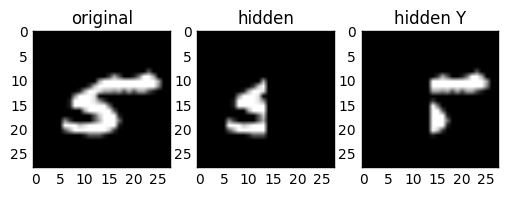

In [5]:
train_hideRight, Xtrain_hideRight, Ytrain_hideRight = hideData(train, generateColumnMask(14))
test_hideRight, Xtest_hideRight, Ytest_hideRight = hideData(test, generateColumnMask(14))

random = np.random.randint(0, 10000)
originalImg = unpackcw(train[:, random], 28, 28)
hiddenImg = unpackcw(train_hideRight[:, random], 28, 28)
hiddenVec = np.concatenate((np.zeros(28*14), Ytrain_hideRight[:, random]), axis = 0)
hiddenPart = unpackcw(hiddenVec, 28, 28)

print train_hideRight.shape
print Xtrain_hideRight.shape
print Ytrain_hideRight.shape
print test_hideRight.shape
print Xtest_hideRight.shape
print Ytest_hideRight.shape

plt.figure(1)
plt.subplot(1, 3, 1); plt.imshow(originalImg, cmap='gray'); plt.title('original')
plt.subplot(1, 3, 2);  plt.imshow(hiddenImg, cmap='gray'); plt.title('hidden')
plt.subplot(1, 3, 3);  plt.imshow(hiddenPart, cmap='gray'); plt.title('hidden Y')

# Tensorflow

In [63]:
# x = every image with zero'd out section as training data
x = tf.placeholder(tf.float32, shape=[None, 784])

# y_ = 14 columns that are being zero'd out
y_ = tf.placeholder(tf.float32, shape=[None, 14*28])

In [64]:
# helper functions
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

In [65]:
# reshape the x data vector into a 28 by 28 image
x_image = tf.reshape(x, [-1,28,28,1])

In [66]:
# first layer of the CNN
W_conv1 = weight_variable([3, 3, 1, 32])
b_conv1 = bias_variable([32])

In [67]:
# convolve x with the weight matrix and add in the bias
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)

In [68]:
# densely connected layer
W_fc1 = weight_variable([24 * 24 * 32, 1024])
b_fc1 = bias_variable([1024])

# reshape vector from convolution
h_conv1_flat = tf.reshape(h_conv1, [-1, 24 *24 * 32])
h_fc1 = tf.nn.relu(tf.matmul(h_conv1_flat, W_fc1) + b_fc1)

In [69]:
# read out layer
W_fc2 = weight_variable([1024, 14 * 28])
b_fc2 = bias_variable([14 * 28])

y_conv = tf.matmul(h_fc1, W_fc2) + b_fc2

In [71]:
# train
cost = tf.nn.l2_loss(y_conv - y_)
train_step = tf.train.AdamOptimizer(1e-4).minimize(cost)

mse = tf.reduce_mean(tf.nn.l2_loss(y_conv - y_))

sess.run(tf.initialize_all_variables())

for i in range(20000):
  batch = mnist.train.next_batch(50)
  if i%100 == 0:
    train_mse = mse.eval(feed_dict={x:batch[0], y_: batch[1]})
    print("step %d, training average mean square error %g"%(i, train_mse))
  train_step.run(feed_dict={x: batch[0], y_: batch[1]})

KeyboardInterrupt: 

In [1]:
# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)


Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [16]:
randomIdxs = np.random.randint(0, 10000, 50)
print randomIdxs.shape
print train_hideRight[:, randomIdxs].shape
print Ytrain_hideRight[:, randomIdxs].shape

(50,)
(784, 50)
(392, 50)


In [10]:
test = np.load('predictedTrain.npy')
test2 = np.load('predictedTest.npy')
print test.shape
print test2.shape

(10000, 392)
(1000, 392)
